In [1]:
%pylab inline
from __future__ import print_function, division

import os
import os.path as osp
import matplotlib.pyplot as plt

from warnings import warn
import datetime, time
import glob as gb
from six import string_types
import argparse
import json
import time
import re

import numpy as np
import scipy.linalg as lin
import scipy.stats as sst


Populating the interactive namespace from numpy and matplotlib


In [2]:
import importlib
from smpce_data_to_corr import get_params
import utils._utils as ucr
import utils.setup_filenames as suf
import correlation2results as c2r
#import tests.test_smpce_data_to_corr as tts
np.set_printoptions(precision=3)

ucr = reload(ucr)
suf = reload(suf)
c2r = reload(c2r)

In [32]:
param_dir = osp.abspath('.')
assert param_dir == '/home/jb/code/simpace/simpace'
params = get_params(param_dir)

basedir = '/home/jb/data/simpace/data/rename_files'
resdir = osp.join(basedir, params['layout']['res']['dir'])
assert osp.isdir(resdir)

fp_anals = gb.glob(osp.join(resdir,'*'))
fp_anals = [f for f in fp_anals if osp.isdir(f)]
ke_anals = [osp.basename(fp_anals[idx]) for idx in range(len(fp_anals))]

pat = r"(.*)_\d\d\d\d_\d\d\d\d\d\d$" #_daymonth_hourminsec
p = re.compile(pat)
ke_anals = [p.match(strin).group(1) for strin in ke_anals if p.match(strin)]
fp_anals = [fp for fp in fp_anals if p.match(fp)]

assert set(['gr_minvox5', 'no_gr_minvox5']).issubset(set(ke_anals))
analrange = range(len(ke_anals))

print("directories found: \n" + "\n".join(fp_anals))
print("keys for analyses are : ",ke_anals)

directories found: 
/home/jb/data/simpace/data/rename_files/results/no_gr_minvox5_0604_004736
/home/jb/data/simpace/data/rename_files/results/gr_minvox5_0604_005252
keys for analyses are :  [u'no_gr_minvox5', u'gr_minvox5']


In [4]:
mtx = params['layout']['res']['corr']
mtxdir = [osp.join(fp_anals[idx], mtx) for idx in  analrange]
npz_anals = [gb.glob(osp.join(mtxdir[idx],"*"))[0] for idx in  analrange]

### Fisher transform

In [5]:
# Fisher z transform of correlation coefficient:

def fisher_transf(rho):
    """ take a coefficient of correlation and z transform it 
        see en.wikipedia.org/wiki/Fisher_transformation
    """
    
    return (0.5 * np.log((1. + rho) / (1. - rho)))

def fisher_corr(corr, _max=None, _min=None):
    """ take a coefficient of correlation and z transform it 
        see en.wikipedia.org/wiki/Fisher_transformation
    """
        
    ok  = np.logical_and(corr < 1.0, corr > -1.0)        
    zcorr = np.zeros_like(corr)
    zcorr[ok] = 0.5 * np.log((1. + corr[ok]) / (1. - corr[ok]))

    if _max:
        # put max for not isnot1
        pass
    if _min:
        # put min for not isnot_1
        pass
    
    return zcorr

### figure 1

In [6]:
# print(npz_anals)

idx_cond = 0

conds_arr = np.load(npz_anals[idx_cond])['conds_arr'][()]
print(osp.basename(npz_anals[idx_cond]))
print(ke_anals[idx_cond])


print(conds_arr['high'].shape)
nb_roi = conds_arr['high'].shape[-1]
for cond in c2r.ordered_conds(): # [none_c, low_c, med_c, high_c]:
    assert np.all(conds_arr[cond] <= 1.) and np.all(conds_arr[cond] >= -1.)
    
ordered_conds = c2r.ordered_conds

no_gr_minvox5.npz
no_gr_minvox5
(11, 89, 89)


-0.708841852953 2.64461397495


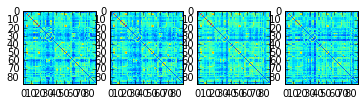

In [7]:
f, axes = plt.subplots(1, 4)
arr = [fisher_corr(conds_arr[c]) for c in ordered_conds()]

vmin = np.asarray(arr).min()
vmax = np.asarray(arr).max()
print(vmin, vmax)

# - np.eye(nb_roi)
for idx, ax in enumerate(axes): 
    ax.imshow(arr[idx].mean(axis=0) , aspect='equal', interpolation='nearest', 
              vmin=vmin, vmax=vmax*.9)


  _no_GR no_gr_minvox5.npz no_gr_minvox5


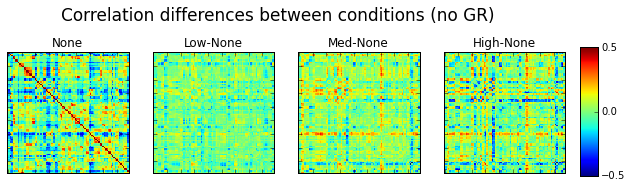

In [8]:
suptitles = ['Correlation differences between conditions (no GR)', 
             'Correlation differences between conditions (GR on)', ]
postfix = ['_no_GR', '_GR']


assert  ke_anals[idx_cond] in osp.basename(npz_anals[idx_cond]) 
print("\n ", postfix[idx_cond],  osp.basename(npz_anals[idx_cond]), ke_anals[idx_cond])

fig, axes = plt.subplots(1, 4)
#arr = [fisher_corr(conds_arr[c]) for c in ordered_conds()]
arr = [conds_arr[c] for c in ordered_conds()]
titles = ['None', 'Low-None', 'Med-None', 'High-None']

for idx, ax in enumerate(axes):
    if idx==0:
        to_display = arr[idx].mean(axis=0)
        vmin = to_display.min()
        vmax = to_display.max()
    else:
        to_display = arr[idx].mean(axis=0) - arr[0].mean(axis=0)
        vmin,vmax = -.5,.5
    cax = ax.imshow(to_display, 
              aspect='equal', interpolation='nearest',
              vmin=vmin, vmax=vmax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(titles[idx])
    

plt.subplots_adjust(top=.95)
fig.suptitle(suptitles[idx_cond], fontsize=17)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([.92, 0.27, 0.025, 0.54])
fig.colorbar(cax, cax=cbar_ax, ticks=[-.5,0,.5])

fig.set_size_inches(10,3.3)
fig.savefig(osp.join(resdir, 'figures', 'corr_diff'+postfix[idx_cond]+'.png'),dpi=100)
#cbar = plt.colorbar(f,orientation='vertical', ticks=[-.5,0,.5])

### Mean and max and std of the differences

In [9]:
a0 = arr[0].mean(axis=0)
for idx, a in enumerate(arr):
    print((a.mean(axis=0) - a0).min(), 
          (a.mean(axis=0) - a0).max(), 
          (a.mean(axis=0) - a0).std(),
         ) 


0.0 0.0 0.0
-0.327065846044 0.224777899798 0.0727733158798
-0.503448631545 0.397690437912 0.0981455017758
-0.712603931487 0.393459900329 0.124772159625


###  Standard deviation per condition across sessions

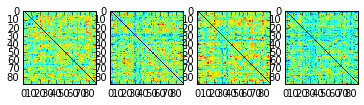

In [10]:
f, axes = plt.subplots(1, 4)
arr = [fisher_corr(conds_arr[c]) for c in ordered_conds()]


for idx, ax in enumerate(axes): 
    ax.imshow(arr[idx].std(axis=0), 
              aspect='equal', interpolation='nearest', vmin=0., vmax=.4)

In [11]:
for idx, a in enumerate(arr):
    print((a.std(axis=0)).max())

0.367300965847
0.431055154189
0.392453950084
0.38674892223


### Look at the highest, smallest and most frequent correlations in "None"

#### compute their min and max, and how they change across conditions

In [12]:
print(arr[0].shape)
print(arr[0].shape[-1])
print(np.triu_indices(arr[0].shape[-1]))

(11, 89, 89)
89
(array([ 0,  0,  0, ..., 87, 87, 88]), array([ 0,  1,  2, ..., 87, 88, 88]))


[(0, 0), (0, 1), (1, 0), (1, 1)]
(0, 0) none 0.378946766904 -0.209364623866 0.949390830556 0.181323552137
(0, 1) low 0.371360547591 -0.159156222036 0.952950733427 0.182549678529
(1, 0) med 0.412477819847 -0.111803153935 0.945673496239 0.175104179011
(1, 1) high 0.384138735418 -0.202615094537 0.917322684223 0.175410053823


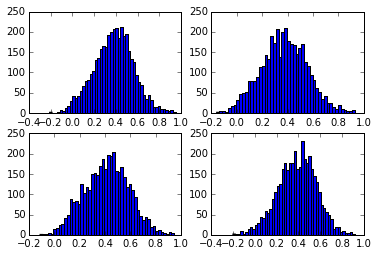

In [13]:
f, axes = plt.subplots(2, 2)
arr = [conds_arr[c] for c in ordered_conds()]
ind_triu = np.triu_indices(arr[0].shape[-1],1)

z = np.where(np.ones((2,2)))
print(zip(z[0],z[1]))

for idx, axcoo in enumerate(zip(z[0],z[1])): 
    mean_ = arr[idx].mean(axis=0)[ind_triu]
    
    print(axcoo, ordered_conds()[idx], mean_.mean(), mean_.min(), mean_.max(), mean_.std())
    h = axes[axcoo[0],axcoo[1]].hist(mean_, bins=50)
    

#### Select some correlations

In [14]:
mean0 = conds_arr['none'].mean(axis=0)
#print(mean0.shape)
#print(ind_triu)

sc95 = sst.scoreatpercentile(mean0[ind_triu], 99)
sc05 = sst.scoreatpercentile(mean0[ind_triu], 1)
sc49_5 = sst.scoreatpercentile(mean0[ind_triu], 49.5)
sc50_5 = sst.scoreatpercentile(mean0[ind_triu], 50.5)

i95 = mean0[ind_triu] > sc95
i05 = mean0[ind_triu] < sc05
i50 = np.logical_and(mean0[ind_triu] > sc49_5, mean0[ind_triu] < sc50_5)


# print(ind_triu[0].shape)
print(i95.shape)

ind95_a0 = ind_triu[0][i95]
ind95_a1 = ind_triu[1][i95]
ind95 = (ind_triu[0][i95], ind_triu[1][i95])

ind05_a0 = ind_triu[0][i05]
ind05_a1 = ind_triu[1][i05]
ind05 = (ind_triu[0][i05], ind_triu[1][i05])

ind50_a0 = ind_triu[0][i50]
ind50_a1 = ind_triu[1][i50]
ind50 = (ind_triu[0][i50], ind_triu[1][i50])

print(ind50_a0.shape, ind05_a0.shape, ind95_a0.shape)
#zip(ind50_a0, ind50_a1)

(3916,)
(40,) (40,) (40,)


In [15]:
rr = []
indstr = ('ind05', 'ind95', 'ind50')
for idx, ind in enumerate([ind05, ind95, ind50]):
    
    print("\n", indstr[idx])
    ind0, ind1  = ind 
    r = np.zeros((ind50_a0.shape[0], 4))
    for i, idx in enumerate(zip(ind0, ind1)):
        ri = [a.mean(axis=0)[idx[0], idx[1]] for a in arr]
        r[i] = ri
    rr.append(r)

    print(r[r.argmin(axis=0)[3]])
    print(r[r.argmax(axis=0)[3]])
    print(r[r.argmin(axis=0)[0]])
    print(r[r.argmax(axis=0)[0]])


 ind05
[-0.05   0.047  0.139 -0.026]
[-0.045  0.075  0.353  0.314]
[-0.209 -0.159 -0.005  0.097]
[-0.037  0.157  0.198  0.097]

 ind95
[ 0.822  0.824  0.791  0.668]
[ 0.888  0.911  0.914  0.917]
[ 0.814  0.853  0.835  0.797]
[ 0.949  0.953  0.928  0.875]

 ind50
[ 0.386  0.105  0.115  0.048]
[ 0.383  0.422  0.506  0.533]
[ 0.383  0.422  0.506  0.533]
[ 0.387  0.273  0.33   0.397]


###  characterizing the difference between none and other conditions:

In [16]:
def mad(a, axis=None):
    """
    Compute Median Absolute Deviation of an array along given axis.
    """
    med = np.median(a, axis=axis)                # Median along given axis
    if axis is None:
        umed = med                              # med is a scalar
    else:
        umed = np.expand_dims(med, axis)         # Bring back the vanished axis
    
    return np.median(np.absolute(a - umed), axis=axis)  # MAD along given axis

In [17]:
idx_cond = 0 # no GR
conds_arr = np.load(npz_anals[idx_cond])['conds_arr'][()]
print(ke_anals[idx_cond])

np.set_printoptions(precision=4)
#f, axes = plt.subplots(1, 3)
arr = np.asarray([conds_arr[c] for c in ordered_conds()])
ind_triu = np.triu_indices(arr[0].shape[-1],1)

#print(np.asarray(ind_triu).shape)

print(arr.shape)
# difference between the low med and high cond and the none
arr = np.asarray([arr[i] - arr[0] for i in [1,2,3]])
print(arr.shape)

print('    Mad       Max       Min      Mean      Std')
print('-----------------------------------------------')
atriu = np.asarray([a[:, ind_triu[0], ind_triu[1]] for a in arr])
for idx, a in enumerate(arr,1):
    print(ordered_conds()[idx])
    am = a.mean(axis=0) # mean across sessions
    
    amp = am
    print(map("{:+3.3f}".format, [mad(amp), amp.max(), amp.min(), 
                                   amp.mean(), amp.std()]))
    amp = am[am>0]
    print(map("{:+3.3f}".format, [mad(amp), amp.max(), amp.min(), 
                                   amp.mean(), amp.std()]))
    
    amp = am[am<0]
    print(map("{:+3.3f}".format, [mad(amp), amp.max(), amp.min(), 
                                   amp.mean(), amp.std()]))
    

no_gr_minvox5
(4, 11, 89, 89)
(3, 11, 89, 89)
    Mad       Max       Min      Mean      Std
-----------------------------------------------
low
['+0.046', '+0.225', '-0.327', '-0.008', '+0.073']
['+0.025', '+0.225', '+0.000', '+0.051', '+0.040']
['+0.031', '-0.000', '-0.327', '-0.063', '+0.051']
med
['+0.060', '+0.398', '-0.503', '+0.033', '+0.098']
['+0.042', '+0.398', '+0.000', '+0.088', '+0.066']
['+0.034', '-0.000', '-0.503', '-0.068', '+0.062']
high
['+0.075', '+0.393', '-0.713', '+0.005', '+0.125']
['+0.047', '+0.393', '+0.000', '+0.094', '+0.072']
['+0.050', '-0.000', '-0.713', '-0.101', '+0.088']


In [18]:
idx_cond = 1 #GR
conds_arr = np.load(npz_anals[idx_cond])['conds_arr'][()]
print(ke_anals[idx_cond])

np.set_printoptions(precision=4)
#f, axes = plt.subplots(1, 3)
arr = np.asarray([conds_arr[c] for c in ordered_conds()])
ind_triu = np.triu_indices(arr[0].shape[-1],1)

#print(np.asarray(ind_triu).shape)

print(arr.shape)
# difference between the low med and high cond and the none
arr = np.asarray([arr[i] - arr[0] for i in [1,2,3]])
print(arr.shape)
atriu = np.asarray([a[:, ind_triu[0], ind_triu[1]] for a in arr])
print(atriu.shape)

print('    Mad       Max       Min      Mean      Std')
print('-----------------------------------------------')

for idx, a in enumerate(arr,1):
    print(ordered_conds()[idx])
    am = a.mean(axis=0) # mean across sessions
    
    amp = am
    print(map("{:+3.3f}".format, [mad(amp), amp.max(), amp.min(), 
                                   amp.mean(), amp.std()]))
    amp = am[am>0]
    print(map("{:+3.3f}".format, [mad(amp), amp.max(), amp.min(), 
                                   amp.mean(), amp.std()]))
    
    amp = am[am<0]
    print(map("{:+3.3f}".format, [mad(amp), amp.max(), amp.min(), 
                                   amp.mean(), amp.std()]))
    

gr_minvox5
(4, 11, 89, 89)
(3, 11, 89, 89)
(3, 11, 3916)
    Mad       Max       Min      Mean      Std
-----------------------------------------------
low
['+0.061', '+0.332', '-0.415', '-0.000', '+0.095']
['+0.036', '+0.332', '+0.000', '+0.073', '+0.055']
['+0.040', '-0.000', '-0.415', '-0.077', '+0.062']
med
['+0.073', '+0.504', '-0.519', '-0.006', '+0.116']
['+0.046', '+0.504', '+0.000', '+0.089', '+0.073']
['+0.045', '-0.000', '-0.519', '-0.093', '+0.074']
high
['+0.092', '+0.696', '-0.750', '-0.008', '+0.149']
['+0.053', '+0.696', '+0.000', '+0.112', '+0.091']
['+0.057', '-0.000', '-0.750', '-0.120', '+0.099']


In [19]:
def sum_statistic(conds_arr, randomize=False):
    """ 
    compute per link the sum across session of the difference with "none"
    """
    arr = np.asarray([conds_arr[c] for c in ordered_conds()])     
    
    ind_triu = np.triu_indices(arr[0].shape[-1],1)
    atriu = np.asarray(arr[:,:, ind_triu[0], ind_triu[1]])
    
    sum_arr = np.zeros((atriu.shape[-1],)) # nb of coefficients
    
    for s in range(atriu.shape[1]):
        if randomize:
            none_cond = np.random.choice([0,1,2,3])
        else:
            none_cond = 0
        sess_arr = (atriu[:,s,:] - atriu[none_cond, s, :]).sum(axis=0)
        sum_arr += sess_arr
            
    return sum_arr


In [20]:
idx_cond = 1 #  GR !!! CHANGE FOR other condition 
conds_arr = np.load(npz_anals[idx_cond])['conds_arr'][()]
nsim = 3000
arr_p = np.zeros((ind_triu[0].shape[0],nsim), dtype=np.float32)

for i in range(nsim):
    arr_p[:,i] = sum_statistic(conds_arr, randomize=True)

In [21]:
arr_nop = sum_statistic(conds_arr, randomize=False) #no randomization !

max_arr_p = arr_p.max(axis=0)
min_arr_p = arr_p.min(axis=0)

print(arr_nop.max(), arr_nop.min())

print(sst.percentileofscore(max_arr_p, arr_nop.max()))
print(sst.percentileofscore(min_arr_p, arr_nop.min()))

15.9992444444 -16.6644331433
99.9333333333
0.0


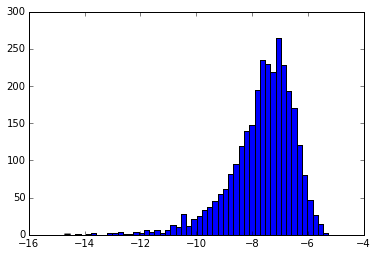

In [22]:
h = plt.hist(min_arr_p, bins=50)

In [23]:
print(sst.scoreatpercentile(max_arr_p, 95.))

9.71073904037


###  How many are affected

In [24]:
(arr_nop > sst.scoreatpercentile(max_arr_p, 95.)).sum()

16

In [25]:
(arr_nop < sst.scoreatpercentile(min_arr_p, 5.)).sum()

25

In [26]:
arr_p_sd = arr_p.std(axis=1)

In [27]:
arr_p_sd.shape

(3916,)

In [28]:
non_corrected_neg = arr_nop < arr_p.mean(axis=1) - 1.64*arr_p.std(axis=1)
non_corrected_pos = arr_nop > arr_p.mean(axis=1) + 1.64*arr_p.std(axis=1)

In [29]:
print('<0: ', non_corrected_neg.sum(), non_corrected_neg.sum()/ arr_nop.shape[0])
print('>0: ',non_corrected_pos.sum(), non_corrected_pos.sum()/ arr_nop.shape[0])

<0:  682 0.174157303371
>0:  587 0.149897854954
